# Filter and Query Records

 This tutorial is part of a series in which we will get to know the `FeedbackDataset`. In this step, we will show how to filter and query our records, a process that can be really useful for efficiently analyzing data, extracting relevant information, managing data size, and enabling focused insights for informed decision-making. You can have a look at the previous tutorials to add [metadata](./add-metadata-003.ipynb), [vectors](./add-vectors-004.ipynb) and [suggestions and responses](./add-suggestions-and-responses-005.ipynb). Feel free to check out the [practical guides](../../../../practical_guides/practical_guides.md) page for more in-depth information.

![workflow](../../../../_static/tutorials/end2end/base/workflow_sort_and_filter.svg)

## Table of contents

1. [Pull the Dataset](#Pull-the-Dataset)
    1. [From Argilla](#From-Argilla)
    2. [From HuggingFace Hub](#From-HuggingFace-Hub)
2. [Filter](#Filter)
    1. [By Fields Content](#By-Fields-Content)
    2. [By Metadata Property](#By-Metadata-Property)
    3. [By Suggestions and Responses](#By-Suggestions-and-Responses)
3. [Sort](#Sort)
4. [Semantic Search](#Semantic-Search)
5. [Conclusion](#Conclusion)

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

**Deploy Argilla on Hugging Face Spaces:** If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/new-space?template=argilla/argilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).

**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../../../getting_started/quickstart.md). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip

This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

First, let's install our dependencies and import the necessary libraries:

In [ ]:
!pip install argilla
!pip install datasets

In [ ]:
import argilla as rg
from argilla._constants import DEFAULT_API_KEY
from sentence_transformers import SentenceTransformer

In order to run this notebook we will need some credentials to push and load datasets from `Argilla` and `🤗 Hub`, let's set them in the following cell:

In [ ]:
# Argilla credentials
api_url = "http://localhost:6900"  # "https://<YOUR-HF-SPACE>.hf.space"
api_key = DEFAULT_API_KEY  # admin.apikey
# Huggingface credentials
hf_token = "hf_..."

Log in to argilla:

In [ ]:
rg.init(api_url=api_url, api_key=api_key)

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running

    tutorial_running()
except ImportError:
    print(
        "Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry."
    )

## Pull the Dataset

As we uploaded the dataset we created in the [previous tutorial](./create-dataset-001.ipynb) to both Argilla and HuggingFace Hub, we can pull the dataset from either of them, however, we only allow filtering and querying on `RemoteFeedbackDataset`, hence we will only pull the dataset from Argilla.

### From Argilla

We can pull the dataset from Argilla by using the `from_argilla` method. 

In [10]:
dataset_remote_with_metadata = rg.FeedbackDataset.from_argilla(
    "end2end_textclassification_with_metadata"
)
dataset_remote_with_vectors = rg.FeedbackDataset.from_argilla(
    "end2end_textclassification_with_vectors"
)
dataset_remote_with_suggestions_and_responses = rg.FeedbackDataset.from_argilla(
    "end2end_textclassification_with_suggestions_and_responses"
)

### From HuggingFace Hub

Not all sorting and filtering is supported with a local `FeedbackDataset`, pulled from HuggingFace Hub. Hence, we will only pull the dataset from Argilla.

<div class="alert alert-info">

Note 

The dataset pulled from HuggingFace Hub is an instance of `FeedbackDataset` whereas the dataset pulled from Argilla is an instance of `RemoteFeedbackDataset`. The difference between the two is that the former is a local one and the changes made on it stay locally. On the other hand, the latter is a remote one and the changes made on it are directly reflected on the dataset on the Argilla server, which can make your process faster.

</div>

## Filter

Filtering allow us to select a subset of the records in our dataset based on a condition. We can filter our dataset by using the `filter_by` method that return a FeedbackDataset with a subset of the records. We can filter by field by metadata property and by status.

> Note: The records won’t be modified unless updates or deletions are specifically applied at record-level.

### By Fields Content

We can filter our dataset by the content of the fields. We will only need to write in the search bar in the top left corner on top of the record card the content you want to filter by. In the image, you can see that we searched for the records with the 'blue' word (which appears highlighted), and two with this requirement were found.

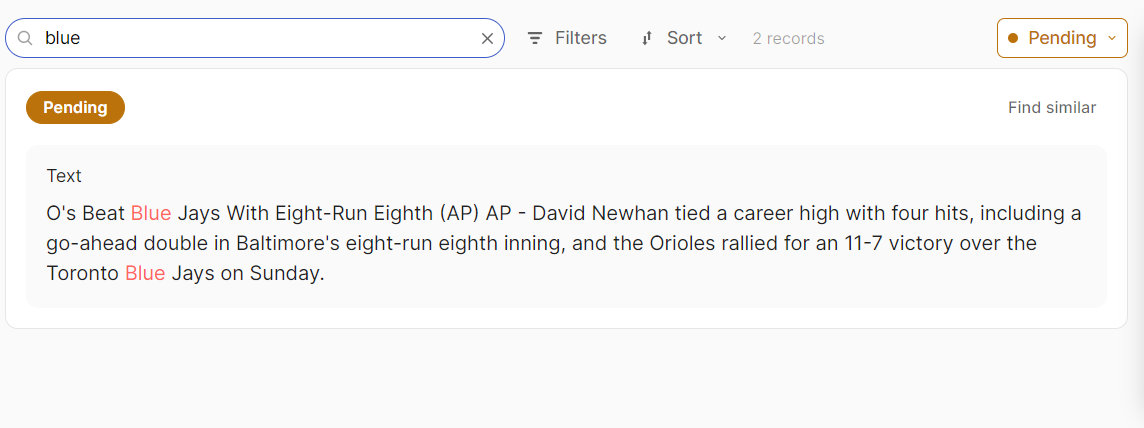

### By Metadata Property

The UI allow us to filter using the metadata properties and combine the needed filter. Below, you can see an example, where we filtered by our metadata `Annotation Group`, `Length of the text` and `Standard Deviation` properties, so that from the 1000 records, we only got 242. Note that if they were set to `visible_for_annotators=False`, it would only appear for users with the `admin` or `owner` role.

> This can also be very useful to assign records to your team members in a common workspace. Please refer to the [metadata tutorial](./add-metadata-003.ipynb) and how to [assign records](./assign-records-002.ipynb) for more information.

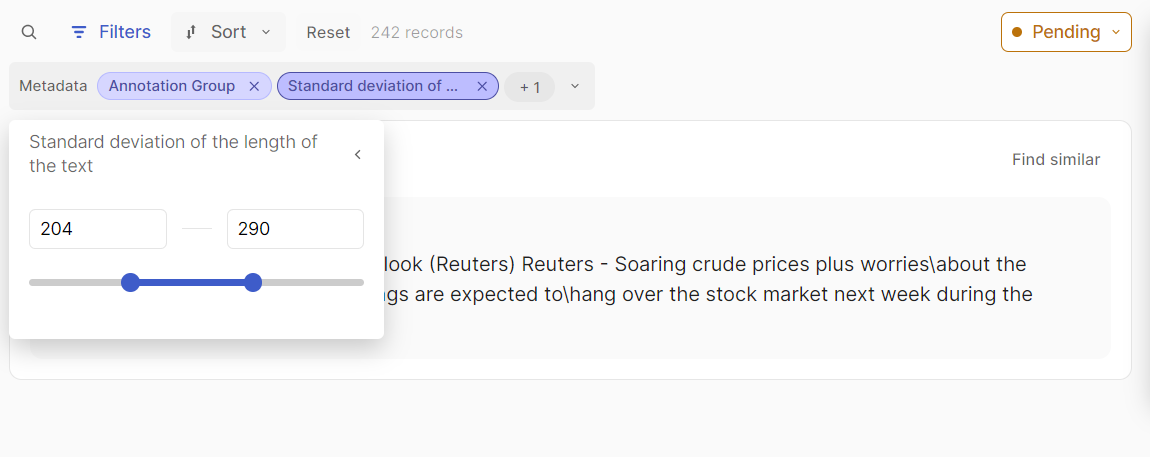

Now, we will make the same filtering but using the `filter_by` method provided in the Python SDK. Thus, we will will need to combine the three filters. In addition, each metadata is a different type, so we will need to use `TermsMetadataFilter` for the annotation group, `IntegerMetadataFilter` for the length of the text, and  `FloatMetadataFilter` for the standard deviation. We will be using the following parameters:

|       | Description      |  TermsMetadataFilter    |  IntegerMetadataFilter    |  FloatMetadataFilter    |
|-------|-------|-------|-------|-------|
|  *name*    | name of the metadata property      | group  | length  | length_std  |
|  *ge*   | values greater than or equal      | no-required  | 0  |  204     |
|  *le*    | values lower than or equal      |  no-required     | 282      |  290     |
|  *values*    |  values searched     |  group-1  and group-2   |  no-required     |  no-required     |

>  In the case of Integer and Float filters at least one of `ge` or `le` should be provided.

In [16]:
filtered_records = dataset_remote_with_metadata.filter_by(
    metadata_filters=[
        rg.TermsMetadataFilter(name="group", values=["group-1", "group-2"]),
        rg.IntegerMetadataFilter(name="length", le=282),
        rg.FloatMetadataFilter(name="length_std", ge=204, le=290),
    ]
)

print(len(filtered_records))

242


### By Status

We can also filter by the status. The `response_status` can be of the following types:

- `missing`, if the records have no responses, or `draft`, if they have them but they are not submitted yet. In both cases, in the UI will appear as `Pending`.
- `discarded`, if the responses were discarded.
- `submitted`, if the responses are submitted.

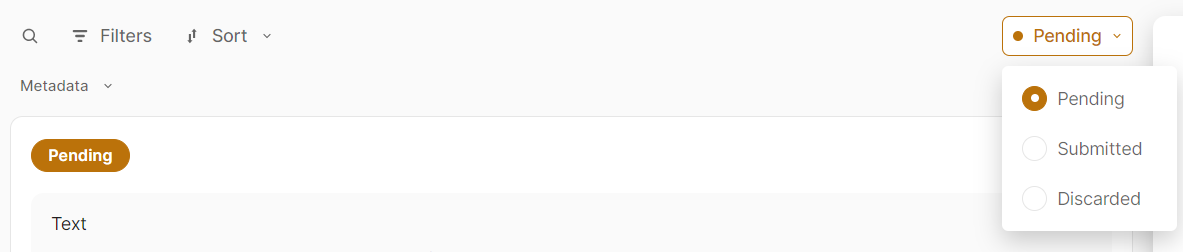

So, now we will use the UI to annotate and discard some samples to be used as examples. And we will start to filter.

* First, we want to check the submitted records so we can compute the time it is taking us to complete the annotation process. And we can see that we still have many work to do.

In [20]:
filtered_dataset = dataset_remote_with_metadata.filter_by(response_status=["submitted"])
print("Submitted records:", len(filtered_dataset))

Submitted records: 10


* Now, we want to check those that are pending, so we will filter by `missing` and `draft` status. And we can see that we have 973 records pending to be annotated.

In [21]:
filtered_dataset = dataset_remote_with_metadata.filter_by(
    response_status=["missing", "draft"]
)
print("Pending records:", len(filtered_dataset))

Pending records: 973


* Finally, we will check how many records were discarded from the filtered records using metadata.

In [28]:
filtered_dataset = dataset_remote_with_metadata.filter_by(
    metadata_filters=[
        rg.TermsMetadataFilter(name="group", values=["group-1", "group-2"]),
        rg.IntegerMetadataFilter(name="length", le=282),
        rg.FloatMetadataFilter(name="length_std", ge=204, le=290),
    ],
    response_status=["discarded"],
)

print("Discarded records:", len(filtered_dataset))

Discarded records: 7


### By Suggestions and Responses

Within the UI filters, you can filter records according to the value of responses given by **the current user**. The type of the questions should be `LabelQuestion`, `MultiLabelQuestion` or `RatingQuestion`. If you prefer to filter records based on suggestions it is possible to gilter by suggestion score, value and agent. The option in Python SDK will be available soon.

## Sort

We can also order the records according to one or several attributes. In the UI, this can be done easily using the `Sort` menu. So, we will focus on how to do it in the Python SDK using `sort_by`. This methos will allow us to sort by the last updated (updated_at) or any metadata properties (metadata.my-metadata-name) in ascending or descending order.

* First, we will sort the records to know the record that was the lasted updated and by groups.

In [39]:
from argilla import SortBy

sorted_records = dataset_remote_with_suggestions_and_responses.sort_by(
    [
        SortBy(field="updated_at", order="desc"),
        SortBy(field="metadata.group", order="asc"),
    ]
)

* Then, we want to order the filtered records in the same way. So, we can combine `filter_by` and `sort_by`.

In [40]:
filtered_dataset = dataset_remote_with_suggestions_and_responses.filter_by(
    response_status=["discarded"]
).sort_by(
    [
        SortBy(field="updated_at", order="desc"),
        SortBy(field="metadata.group", order="asc"),
    ]
)

## Semantic Search

In this section, we will see how to use the semantic search feature in Python SDK. To find similar records, we will use the `find_similar_records` method. We need to feed this method with the vector name we want to use for the search. For the particular vector, we have two options: we can either use a record by the `record` parameter or we can define a new vector by the `vector` parameter. You can limit the number of records you want to get by the `max_results` parameter. 

> It is also possible to use the semantic search in the UI. You will just need to click the `Find Similar` button on the right top of the record to see similar records. You have the opportunity to limit the number of results as well as define your research as the most or least similar records. You can also see the similarity score of each record to the record you are searching for.

In [ ]:
similar_records = dataset_remote_with_vectors.find_similar_records(
    vector_name="sentence_embedding",
    record=dataset_remote_with_vectors[0],
    max_results=5,
)

The `similar_records` object we created contains the 5 top records similar to the first record in the dataset. Let us see what these records are.

In [ ]:
[record[0].fields["text"] for record in similar_records]

["Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.",
 "Strategies for a Sideways Market (Reuters) Reuters - The bulls and the bears are in this\\together, scratching their heads and wondering what's going to\\happen next.",
 "Strategies for a Sideways Market  WASHINGTON (Reuters) - The bulls and the bears are in this  together, scratching their heads and wondering what's going to  happen next.",
 'Wall Street to Open Little Changed  NEW YORK (Reuters) - Wall Street is seen opening little  changed on Monday as crude prices remain high, but insurers may  dip on worries about their potential liabilities after a  hurricane struck Florida on Friday.',
 "Chrysler's Bling King After a tough year, Detroit's troubled carmaker is back -- thanks to a maverick designer and a car that is dazzling the hip-hop crowd"]

On the other hand, we can feed the `find_similar_records` method with a vector we define. Let us first create an embedding with the sentence transformers model and then find the records similar to this vector.

In [ ]:
text = "Baseball: Smoltz sizzles as Braves force deciding game HOUSTON, United States : JD Drew singled to drive in a run in the top of the ninth inning and lift the Atlanta Braves to a 6-5 win over Houston and force the Astros into a fifth and deciding game."

model = SentenceTransformer("TaylorAI/bge-micro")

text_vector = model.encode(text).tolist()

similar_records = dataset_remote_with_vectors.find_similar_records(
    vector_name="sentence_embedding", value=text_vector, max_results=5
)

We can see the ids of the records that are similar to the vector we defined.

In [ ]:
[record[0].external_id for record in similar_records]

['record-746', 'record-459', 'record-642', 'record-716', 'record-643']

## Conclusion

In this tutorial, we learned how to filter and query our records. We delved into the specifics of filtering based on field content, metadata attributes, various statuses and suggestions and responses. Additionally, we explored methods to order our records, whether by the most recent updates or by any metadata characteristic. Finally, we saw how to use the semantic search feature.